# Predict Bike Sharing Demand with AutoGluon Template

### Install packages

In [1]:
%pip install -U pip
%pip install -U setuptools wheel
%pip install -U "mxnet<2.0.0" bokeh==2.0.1
%pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Using cached setuptools-70.3.0-py3-none-any.whl.metadata (5.8 kB)
Using cached setuptools-70.3.0-py3-none-any.whl (931 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 20.1 MB/s eta 0:00:00
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080016 sha256=f82bb80376dba60db70fe2b27a759170f3dd526eb56108f7878314c1b77bffec
  Stored in directory: /root/.cache/pip/wheels/be/b4/d8/7ce778fd6e637bea03a561223a77ba6649aff8168e3c613754
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.3.4
    Uninstalling bokeh-3.3.4:
      Successfully uninstalled bokeh-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.3.8 requires bokeh<3.4.0,

### Setup Kaggle API Key

In [1]:
# Install Kaggle API client
!pip install -q Kaggle

# Upload Kaggle API token (json file) -- (Uncomment) Only for Google Colab (For AWS Sagemaker upload 'kaggle.json')
from google.colab import files
files.upload()

# create a kaggle directory
!mkdir ~/.kaggle

Saving kaggle.json to kaggle.json


In [2]:
# copy 'kaggle.json' (Kaggle API Token) to the folder we have created
!cp kaggle.json ~/.kaggle/

# Authorize permissions for the json to act
!chmod 600 ~/.kaggle/kaggle.json

# Download the Bike Sharing Demand dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand

# # Unzip Dataset (Over-write to avoid error, if the dataset pre-exists)
!unzip -o bike-sharing-demand.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 99.9MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


### Download and explore dataset

In [3]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [4]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv",parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.

In [5]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv",parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv",parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [7]:
# Checking all the features and target variable in the dataset
print("Columns in Train Dataset:\n", train.columns)
print("\nColumns in Test Dataset:\n", test.columns)

Columns in Train Dataset:
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

Columns in Test Dataset:
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


In [8]:
# Variables not present in test dataset
print("Variables that are not present in the test dataset: ")
list(set(train.columns).difference(set(test.columns)))

Variables that are not present in the test dataset: 


['registered', 'casual', 'count']

## Observation :
Since, `count` is the predicted/dependent variable whereas `casual` and `registered` are independent variables which aren't present in the test dataset, hence, ignoring these two predictor variables/columns from the train dataset.

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset.
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [9]:
# Requirements: For AutoGluon's Tabular Predictions
eval_metric = 'root_mean_squared_error'
label = 'count'
ignored_columns = ["casual", "registered"]
train_data = train
time_limit = 600
presets = "best_quality"

In [10]:
predictor = TabularPredictor(label=label,
                             problem_type= 'regression',
                             eval_metric=eval_metric,
                             learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                           train_data = train_data,
                                                                           time_limit=time_limit,
                                                                           presets=presets)

No path specified. Models will be saved in: "AutogluonModels/ag-20240712_095935"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       11.33 GB / 12.67 GB (89.4%)
Disk Space Avail:   76.23 GB / 107.72 GB (70.8%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be

(_ray_fit pid=3100) [1000]	valid_set's rmse: 130.657
(_ray_fit pid=3099) [3000]	valid_set's rmse: 128.461 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=3262) [1000]	valid_set's rmse: 132.725
(_ray_fit pid=3301) [1000]	valid_set's rmse: 128.154
(_ray_fit pid=3301) [2000]	valid_set's rmse: 126.702
(_ray_fit pid=3301) [3000]	valid_set's rmse: 126.147
(_ray_fit pid=3301) [4000]	valid_set's rmse: 125.904
(_ray_fit pid=3371) [1000]	valid_set's rmse: 135.845
(_ray_fit pid=3301) [7000]	valid_set's rmse: 125.4 [repeated 5x across cluster]
(_ray_fit pid=3371) [7000]	valid_set's rmse: 132.416 [repeated 5x across cluster]
(_ray_fit pid=3491) [1000]	valid_set's rmse: 137.712 [repeated 3x across cluster]
(_ray_fit pid=3491) [4000]	valid_set's rmse: 135.344 [repeated 3x across cluster]
(_ray_fit pid=3491) [6000]

(_dystack pid=2941) 	-131.9758	 = Validation score   (-root_mean_squared_error)
(_dystack pid=2941) 	81.77s	 = Training   runtime
(_dystack pid=2941) 	9.75s	 = Validation runtime
(_dystack pid=2941) Fitting model: LightGBM_BAG_L1 ... Training model for up to 1.42s of the 48.57s of remaining time.
(_dystack pid=2941) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.08%)
(_dystack pid=2941) 	-141.5853	 = Validation score   (-root_mean_squared_error)
(_dystack pid=2941) 	22.91s	 = Training   runtime
(_dystack pid=2941) 	0.06s	 = Validation runtime
(_dystack pid=2941) Fitting model: WeightedEnsemble_L2 ... Training model for up to 141.41s of the 19.56s of remaining time.
(_dystack pid=2941) 	Ensemble Weights: {'KNeighborsDist_BAG_L1': 1.0}
(_dystack pid=2941) 	-89.9469	 = Validation score   (-root_mean_squared_error)
(_dystack pid=2941) 	0.04s	 = Training   runtime
(_dystack pid=2941) 	0.0s	 = Validation runtime

(_ray_fit pid=4012) [1000]	valid_set's rmse: 71.058
(_ray_fit pid=4011) [1000]	valid_set's rmse: 69.7032
(_ray_fit pid=4111) [1000]	valid_set's rmse: 78.779
(_ray_fit pid=4112) [1000]	valid_set's rmse: 73.4667
(_ray_fit pid=4239) [1000]	valid_set's rmse: 76.6872
(_ray_fit pid=4211) [1000]	valid_set's rmse: 76.4036
(_ray_fit pid=4311) [1000]	valid_set's rmse: 73.1796
(_ray_fit pid=4344) [1000]	valid_set's rmse: 75.297


(_dystack pid=2941) 	-74.2286	 = Validation score   (-root_mean_squared_error)
(_dystack pid=2941) 	42.5s	 = Training   runtime
(_dystack pid=2941) 	2.17s	 = Validation runtime
(_dystack pid=2941) Fitting model: WeightedEnsemble_L3 ... Training model for up to 141.41s of the -27.95s of remaining time.
(_dystack pid=2941) 	Ensemble Weights: {'LightGBMXT_BAG_L2': 0.955, 'KNeighborsDist_BAG_L1': 0.045}
(_dystack pid=2941) 	-74.1897	 = Validation score   (-root_mean_squared_error)
(_dystack pid=2941) 	0.03s	 = Training   runtime
(_dystack pid=2941) 	0.0s	 = Validation runtime
(_dystack pid=2941) AutoGluon training complete, total runtime = 169.53s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 100.8 rows/s (1210 batch size)
(_dystack pid=2941) TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20240712_095935/ds_sub_fit/sub_fit_ho")
(_dystack pid=2941) Deleting DyStack predictor artifacts (clean_up_fits=True) ...
Leaderboard o

### Review AutoGluon's training run with ranking of models that did the best.

In [11]:
predictor = TabularPredictor.load("AutogluonModels/ag-20240712_095935")

In [12]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.181741  root_mean_squared_error      21.772583  406.142239                0.000860           0.035145            3       True         12
1   RandomForestMSE_BAG_L2  -53.485239  root_mean_squared_error      17.697420  308.766023                0.866161          47.664693            2       True         11
2          LightGBM_BAG_L2  -55.148431  root_mean_squared_error      17.301698  294.511176                0.470438          33.409846            2       True         10
3        LightGBMXT_BAG_L2  -60.362685  root_mean_squared_error      20.435123  325.032554                3.603864          63.931224            2       True          9
4    KNeighborsDist_BAG_L1  -84.125061  root_mean_squared_error       0.057963    0.034853   

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -130.94147961817637,
  'ExtraTreesMSE_BAG_L1': -124.60067564699747,
  'WeightedEnsemble

### Create predictions from test dataset

In [ ]:
predictions = ?
predictions.head()

In [13]:
leaderboard_df = pd.DataFrame(predictor.leaderboard(silent=True))
leaderboard_df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-53.181741,root_mean_squared_error,21.772583,406.142239,0.000860,0.035145,3,True,12
1,RandomForestMSE_BAG_L2,-53.485239,root_mean_squared_error,17.697420,308.766023,0.866161,47.664693,2,True,11
2,LightGBM_BAG_L2,-55.148431,root_mean_squared_error,17.301698,294.511176,0.470438,33.409846,2,True,10
3,LightGBMXT_BAG_L2,-60.362685,root_mean_squared_error,20.435123,325.032554,3.603864,63.931224,2,True,9
4,KNeighborsDist_BAG_L1,-84.125061,root_mean_squared_error,0.057963,0.034853,0.057963,0.034853,1,True,2
5,WeightedEnsemble_L2,-84.125061,root_mean_squared_error,0.058857,0.060953,0.000895,0.026100,2,True,8
6,KNeighborsUnif_BAG_L1,-101.546199,root_mean_squared_error,0.048141,0.038409,0.048141,0.038409,1,True,1
7,RandomForestMSE_BAG_L1,-116.548359,root_mean_squared_error,0.595915,20.628691,0.595915,20.628691,1,True,5
8,ExtraTreesMSE_BAG_L1,-124.600676,root_mean_squared_error,0.568969,12.881877,0.568969,12.881877,1,True,7
9,CatBoost_BAG_L1,-130.941480,root_mean_squared_error,0.193749,110.021186,0.193749,110.021186,1,True,6


#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [14]:
# Describe the `predictions` series to see if there are any negative values
predictions = predictor.predict(test)
predictions.head()

0    23.758957
1    42.155655
2    45.604542
3    48.378632
4    50.957642
Name: count, dtype: float32

In [15]:
# How many negative values do we have?
predictions.describe()

count    6493.000000
mean      100.477127
std        89.904343
min         3.311211
25%        19.686817
50%        64.096237
75%       167.322647
max       367.302917
Name: count, dtype: float64

In [16]:
# Set them to zero
negative_pred_count = predictions.apply(lambda x: 1 if x<0 else 0)

pred_pos_count = (negative_pred_count==0).sum()
pred_neg_count = (negative_pred_count==1).sum()

print("Total predictions                :", len(predictions.index))
print("Total positive prediction values :", pred_pos_count)
print("Total negative prediction values :", pred_neg_count)

Total predictions                : 6493
Total positive prediction values : 6493
Total negative prediction values : 0


In [17]:
# Set them to zero
predictions[predictions<0] = 0    # (In case, if negative values exist in the predictions, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No. of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")

No. of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


### Set predictions to submission dataframe, save, and submit

In [18]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [19]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:00<00:00, 272kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [20]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2024-07-12 10:14:57  first raw submission  complete  1.80302      1.80302       




#### Initial score of `1.80302 `

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

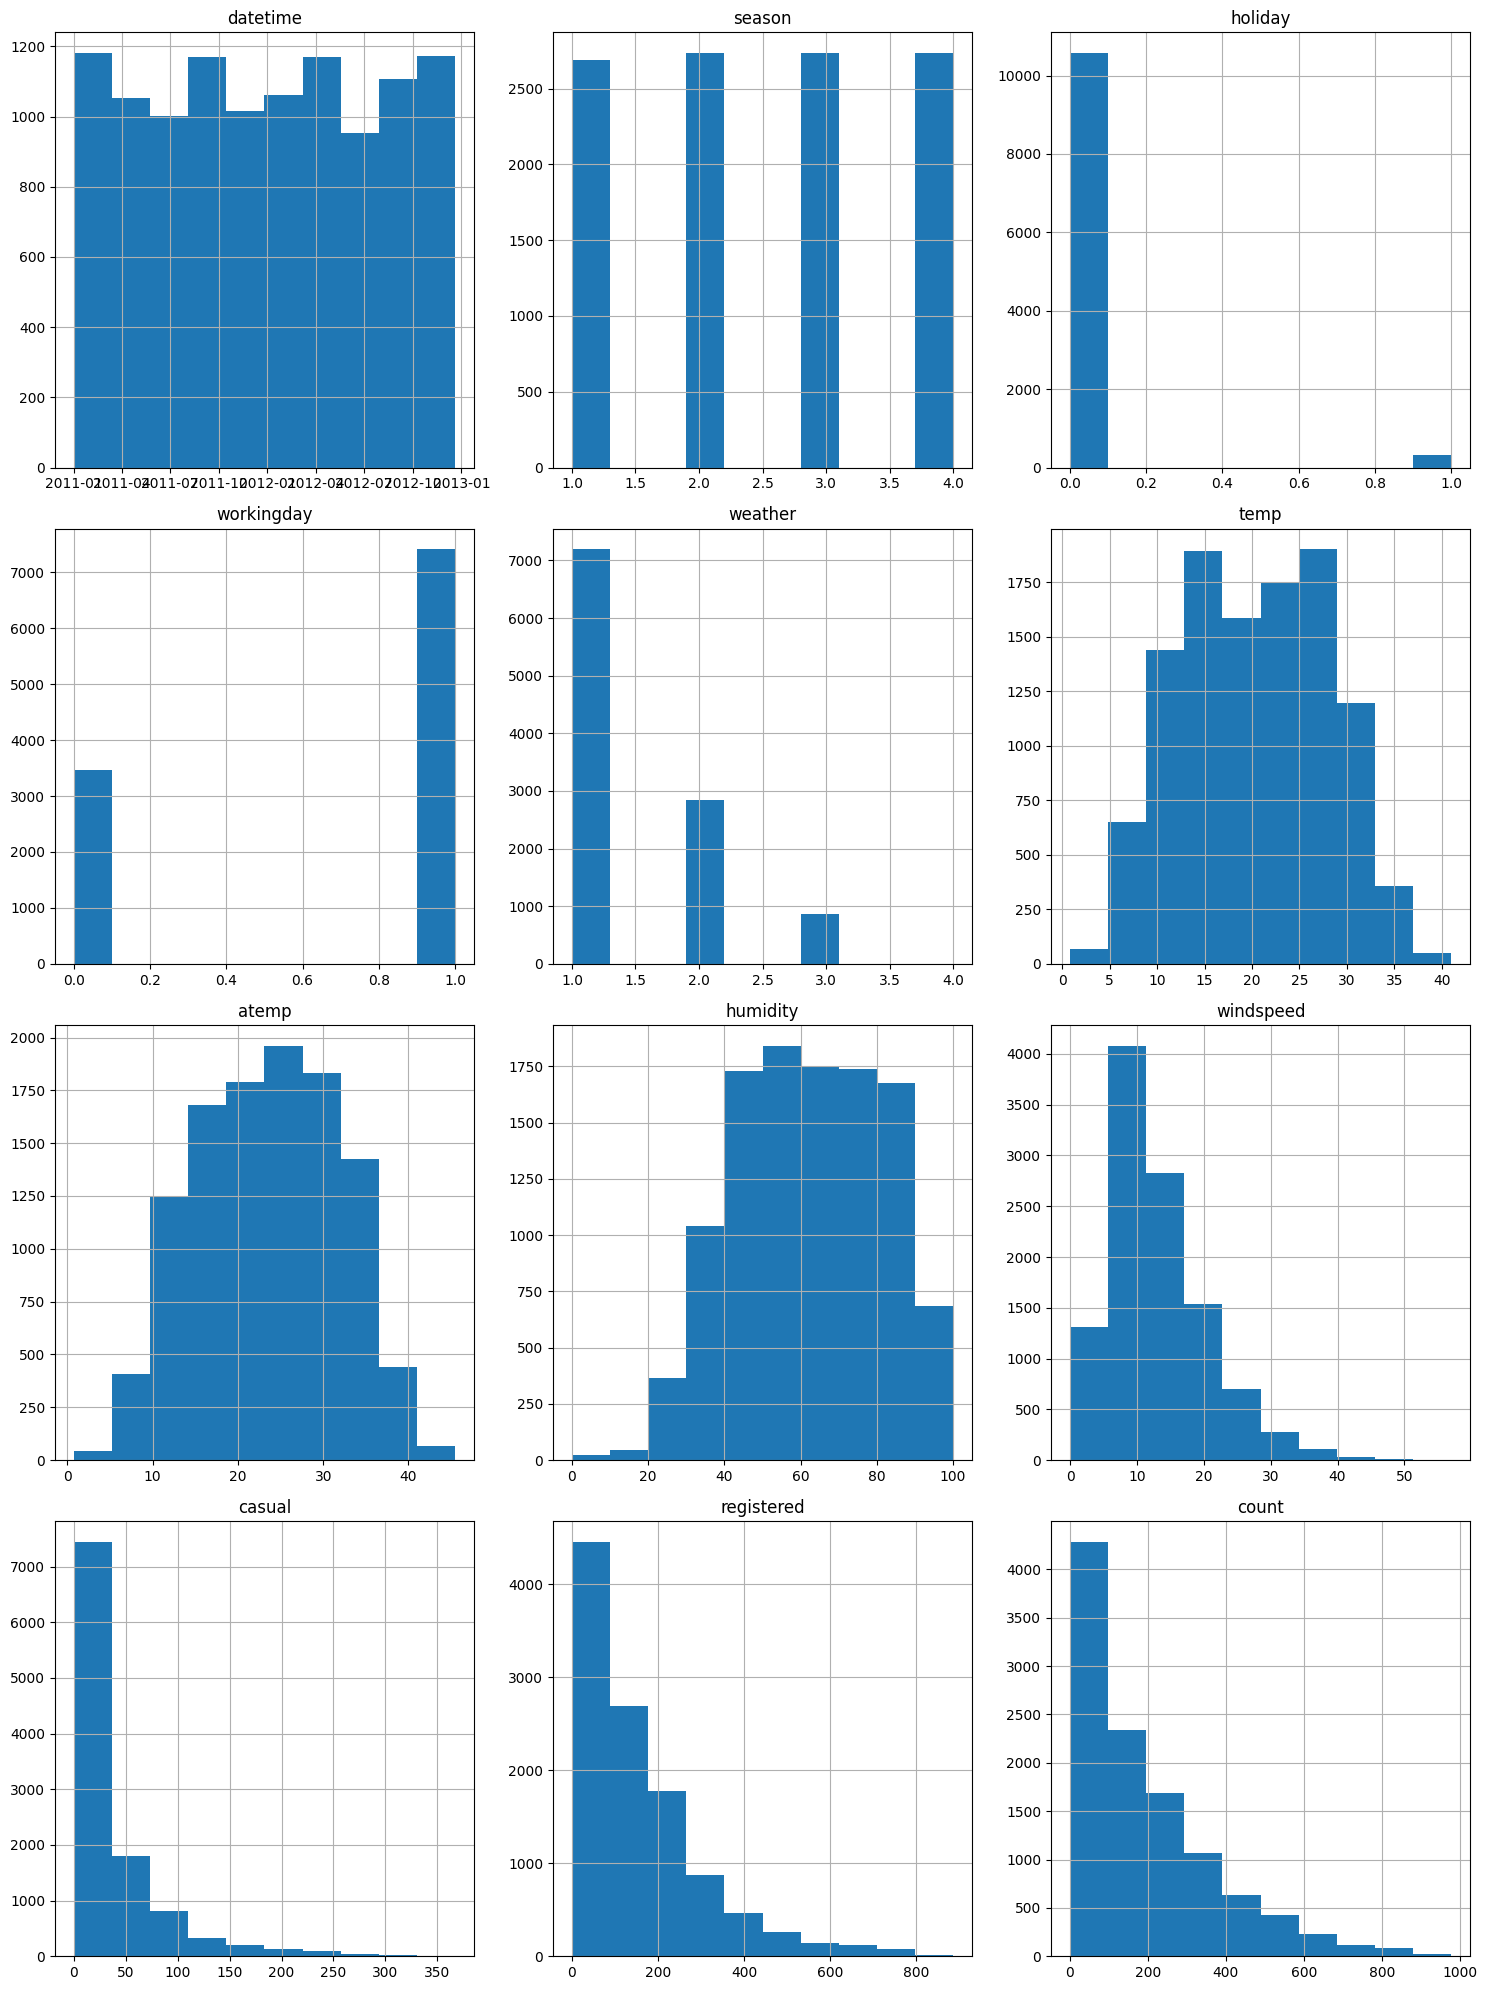

In [21]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(15,20))  # Note: 'casual' and 'registered' are ignored during training as they are absent in test data

plt.tight_layout()
plt.show()

## Observations:

Features like `season` and `weather` are categorical variables and it is evident from the above plot.

`Bike rental counts` for feature `season` intuitively makes sense as the counts are highest for 0: Spring season and the lowest for 3: Winter season. These `counts decrease as seasons change from Spring -> Summer -> Fall -> Winter.`

Predictors like holiday and workingday are one-hot encoded columns with values 0 and 1. Highest rental counts are noticed during non-holidays whereas more rental counts are encountered during working days.
datetime histogram illustrates datetime feature, showing randomness as they represent timestamps

Plots of predictor features like `temp`, `atemp`, `humidity` and `windspeed` depicts normal distribution. windspeed shows a slightly 'positively-skewed distribution'.

`casual` and `registered` independent feature histogram plots are ignored as they are invalid for our analysis, since they are absent in the test dataset.

In [22]:
# Splitting the 'datetime' feature in train data
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.dayofweek
train["hour"] = train["datetime"].dt.hour
train.drop(["datetime"], axis=1, inplace=True)
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4


In [23]:
# Splitting the 'datetime' feature in test data
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.dayofweek  # Note: day -> dayofweek (0->Monday, 6->Sunday)
test["hour"] = test["datetime"].dt.hour
test.drop(["datetime"], axis=1, inplace=True)   # Drop 'datetime' feature
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,3,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,4


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [24]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")

test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [25]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4


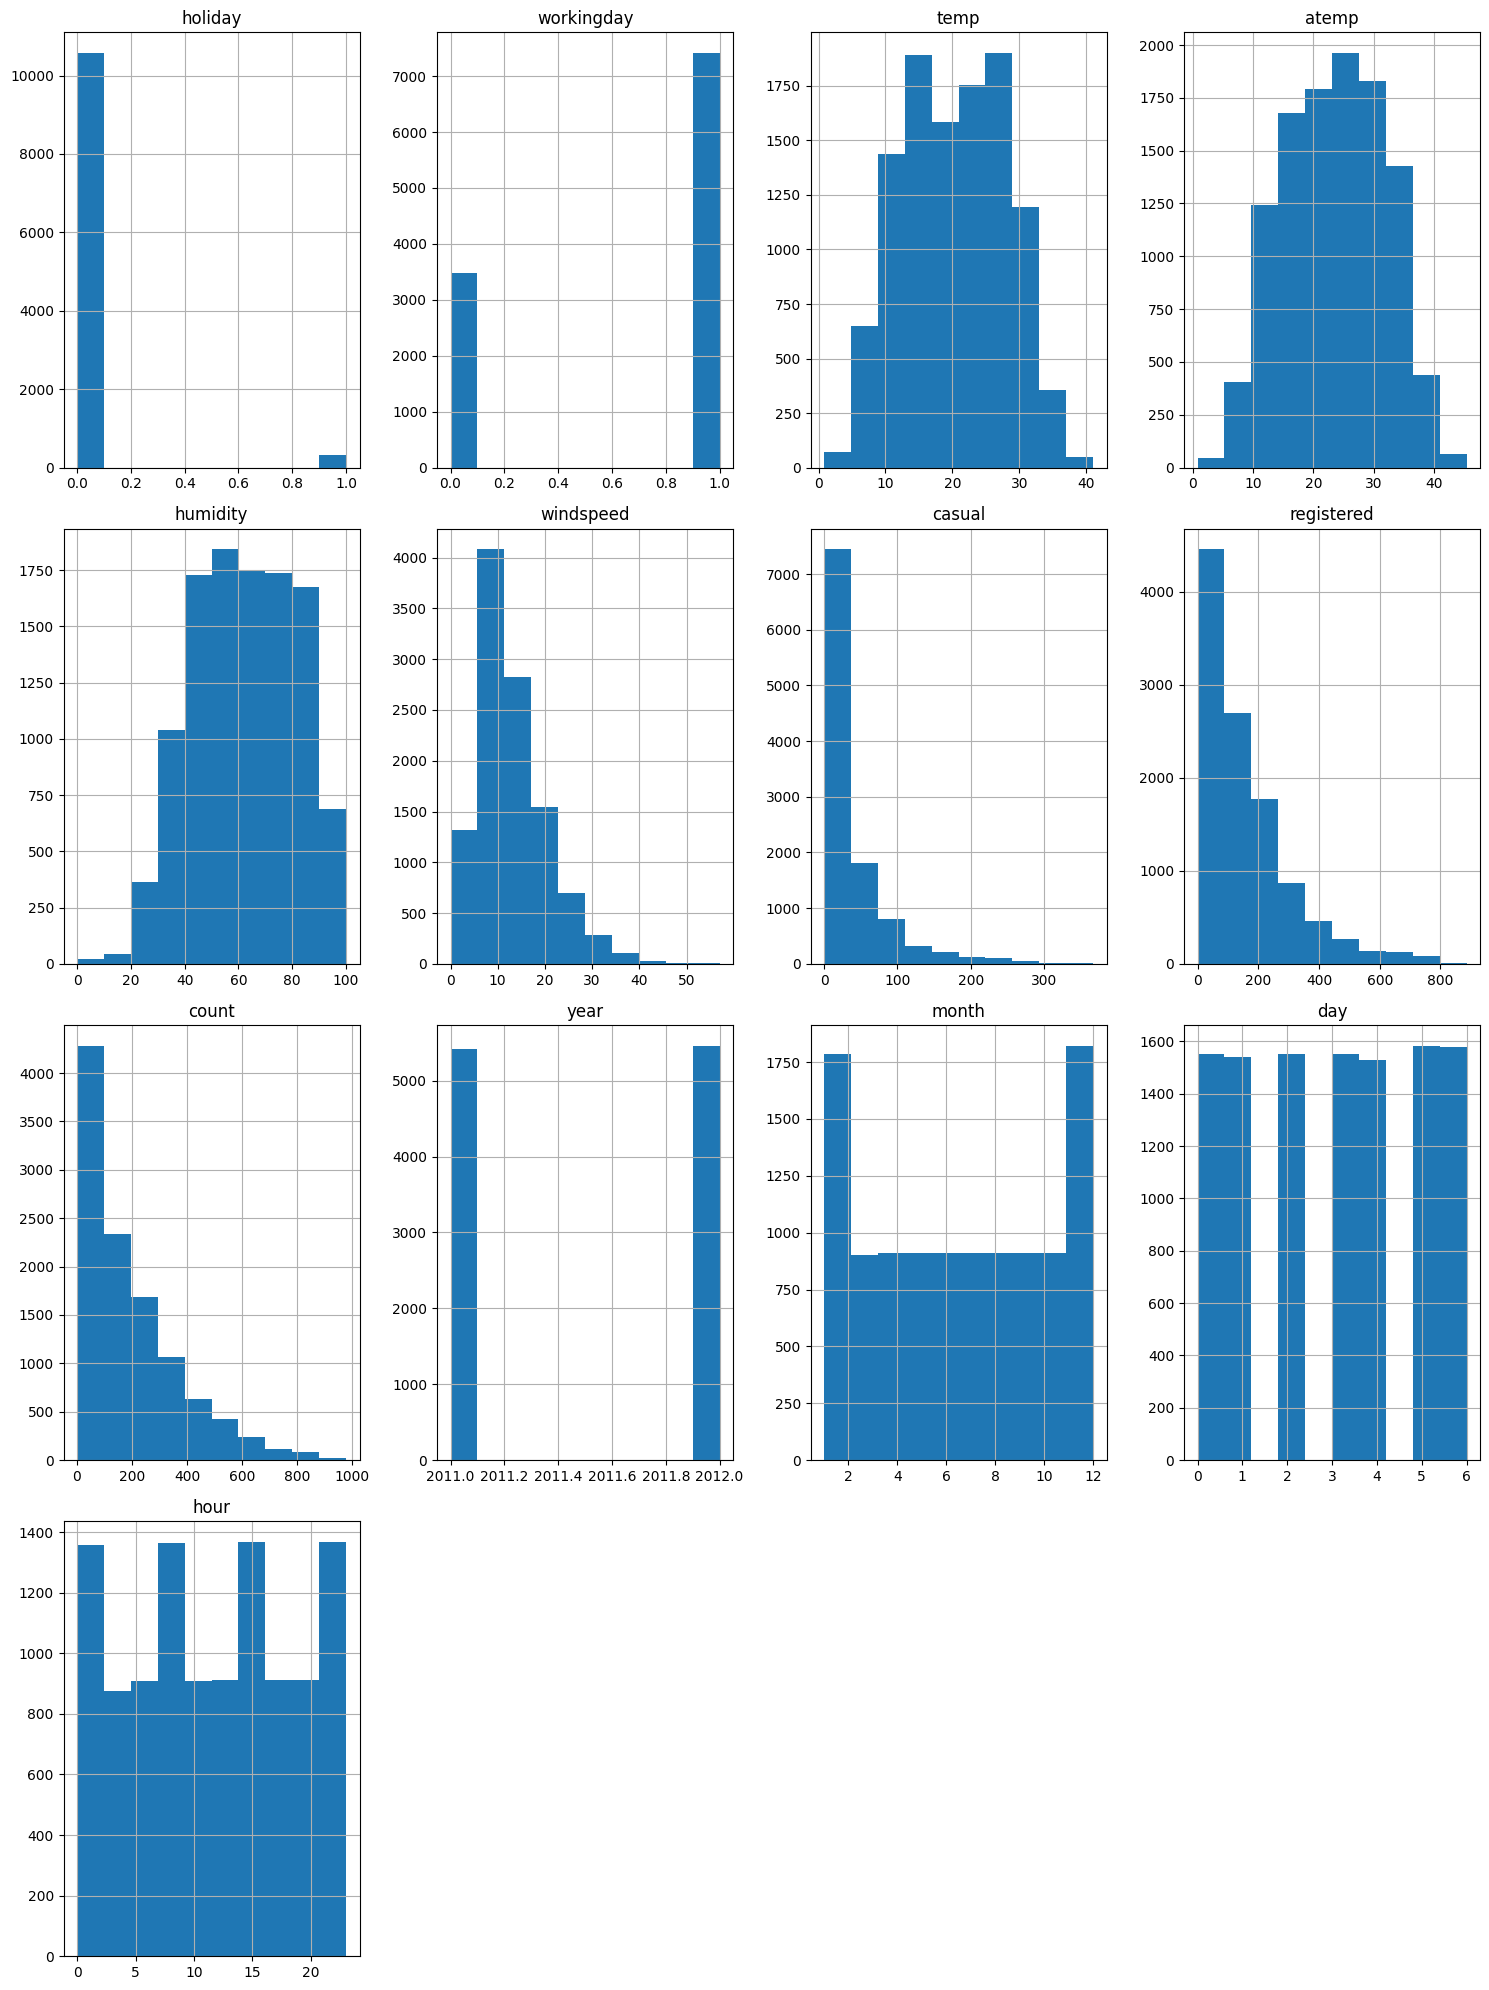

In [26]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,20))  # Note: 'casual' and 'registered' are ignored during training as they are absent in test data

plt.tight_layout()
plt.show()

In [27]:
# New feature 'day_type' contains categories 'weekend', 'weekday', or 'holiday' (In Train and Test set)

# Adding features - 'day_type' in train data
train["day_type"]=""
train.loc[(train.holiday==1),"day_type"] = "holiday"
train.loc[((train.holiday==0) & (train.workingday==1)), "day_type"] = "weekday"
train.loc[((train.holiday==0) & (train.workingday==0)), "day_type"] = "weekend"

# Adding features - 'day_type' in test data
test["day_type"]=""
test.loc[(test.holiday==1),"day_type"] = "holiday"
test.loc[((test.holiday==0) & (test.workingday==1)), "day_type"] = "weekday"
test.loc[((test.holiday==0) & (test.workingday==0)), "day_type"] = "weekend"

# Change the datatype to category
train["day_type"] = train["day_type"].astype("category")
test["day_type"] = test["day_type"].astype("category")

train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,day_type
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0,weekend
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1,weekend
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2,weekend
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3,weekend
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4,weekend


In [28]:
# Dropping highly correlated independent feature 'atemp' from train and test datasets
train.drop(["atemp"], axis=1, inplace=True)
test.drop(["atemp"], axis=1, inplace=True)

## Step 5: Rerun the model with the same settings as before, just with more features

In [29]:

eval_metric = 'root_mean_squared_error'
label = 'count'
ignored_columns = ["casual", "registered"]
train_data = train
time_limit = 600
presets = "best_quality"

In [30]:
predictor_new_features = TabularPredictor(label=label,
                                          problem_type= 'regression',
                                          eval_metric=eval_metric,
                                          learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                                           train_data = train_data,
                                                                                           time_limit=time_limit,
                                                                                           presets=presets)

No path specified. Models will be saved in: "AutogluonModels/ag-20240712_102523"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.95 GB / 12.67 GB (78.5%)
Disk Space Avail:   75.25 GB / 107.72 GB (69.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

In [31]:
predictor = TabularPredictor.load("AutogluonModels/ag-20240712_102523")

In [32]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -34.322973  root_mean_squared_error      27.066264  381.974013                0.001267           0.051949            3       True         12
1      WeightedEnsemble_L2  -34.410579  root_mean_squared_error      24.580897  252.344766                0.001140           0.040972            2       True          7
2          LightGBM_BAG_L2  -34.955565  root_mean_squared_error      25.488184  280.670331                0.542030          28.274519            2       True          9
3          CatBoost_BAG_L2  -35.299541  root_mean_squared_error      25.103997  279.918627                0.157844          27.522814            2       True         11
4        LightGBMXT_BAG_L2  -35.333643  root_mean_squared_error      25.673064  284.432404   

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -113.26164315463612,
  'KNeighborsDist_BAG_L1': -109.84517207130654,
  'LightGBMXT_BAG_L1': -36.7080198842608,
  'LightGBM_BAG_L1': -35.78035548163389,
  'RandomForestMSE_BAG_L1': -39.71723944004303,
  'CatBoost_BAG_L1': -39.12860480606242,
  'WeightedEnsemble_L2': -34.41057884528434,
  'LightGBMXT_BAG_L2':

In [33]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    14.187486
1     5.607569
2     4.131298
3     3.153103
4     3.138086
Name: count, dtype: float32

In [34]:
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features<0] = 0    # (In case, if negative values exist in the predictions_new_features, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions_new_features.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No. of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")


No. of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


In [36]:
# Same thing as train and test dataset
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [37]:
# Same submitting predictions
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [38]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:00<00:00, 365kB/s]
Successfully submitted to Bike Sharing Demand

In [39]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2024-07-12 10:39:21  new features          complete  0.48478      0.48478       
submission.csv               2024-07-12 10:14:57  first raw submission  complete  1.80302      1.80302       


#### New Score of `0.48478 `

In [40]:
eval_metric = 'root_mean_squared_error'
label = 'count'
ignored_columns = ["casual", "registered"]   # Ignored columns while training
train_data = train                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 600                             # 10 minutes -> 60*10 = 600 seconds
presets = "optimize_for_deployment"

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [46]:
import autogluon.common as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([100], [1000], [200, 100], [300, 200, 100]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   #'NN': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

#num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    #'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor_new_hpo = TabularPredictor(label="count", eval_metric="root_mean_squared_error",learner_kwargs={"ignored_columns":
["casual", "registered"]}).fit(train_data=train, time_limit=600, presets="best_quality", hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)


No path specified. Models will be saved in: "AutogluonModels/ag-20240712_105108"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.80 GB / 12.67 GB (77.3%)
Disk Space Avail:   74.56 GB / 107.72 GB (69.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

In [47]:
predictor = TabularPredictor.load("AutogluonModels/ag-20240712_105108")

In [49]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L3  -37.569304  root_mean_squared_error       2.869796  360.582799                0.001301           0.044702            3       True         15
1    LightGBM_BAG_L2/T1  -37.966221  root_mean_squared_error       2.508285  294.339827                0.182569          32.523309            2       True         10
2   WeightedEnsemble_L2  -38.004769  root_mean_squared_error       0.659508   66.788888                0.001307           0.086256            2       True          9
3    LightGBM_BAG_L2/T3  -38.041835  root_mean_squared_error       2.523625  295.653468                0.197908          33.836950            2       True         12
4    LightGBM_BAG_L2/T2  -38.111701  root_mean_squared_error       2.488019  294.177838                0.162

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T6': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T7': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T8': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T5': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -42.50765749338071,
  'LightGBM_BAG_L1/T2': -40.75871996171395,
  'LightGBM_BAG_L1/T3': -40.426384739072795,
  'LightGBM_BAG_L1/T4': -122.01736228393139,
  'LightG

In [50]:
# Remember to set all negative values to zero
new_predictions_hpo = predictor_new_hpo.predict(test)
new_predictions_hpo[new_predictions_hpo<0] = 0

In [51]:
# Same submitting predictions
submission_new_hpo = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_hpo["count"] = new_predictions_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [52]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:00<00:00, 342kB/s]
Successfully submitted to Bike Sharing Demand

In [53]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-07-12 11:03:31  new features with hyperparameters  complete  0.48281      0.48281       
submission_new_features.csv  2024-07-12 10:39:21  new features                       complete  0.48478      0.48478       
submission.csv               2024-07-12 10:14:57  first raw submission               complete  1.80302      1.80302       


#### New Score of `0.48281`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

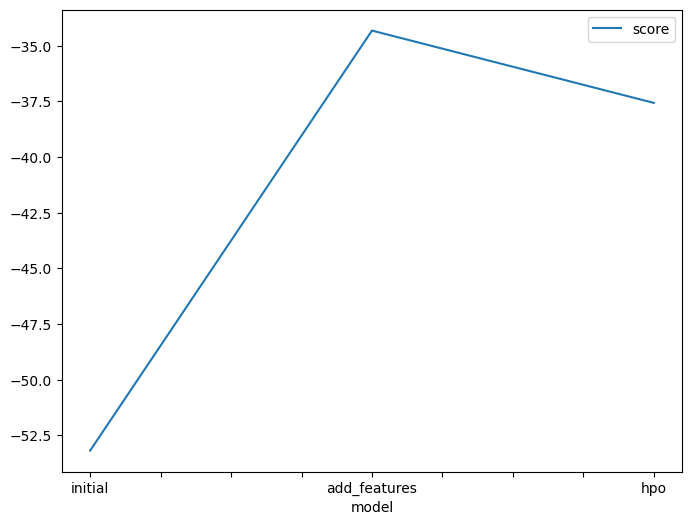

In [54]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-53.181741, -34.322973, -37.569304]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

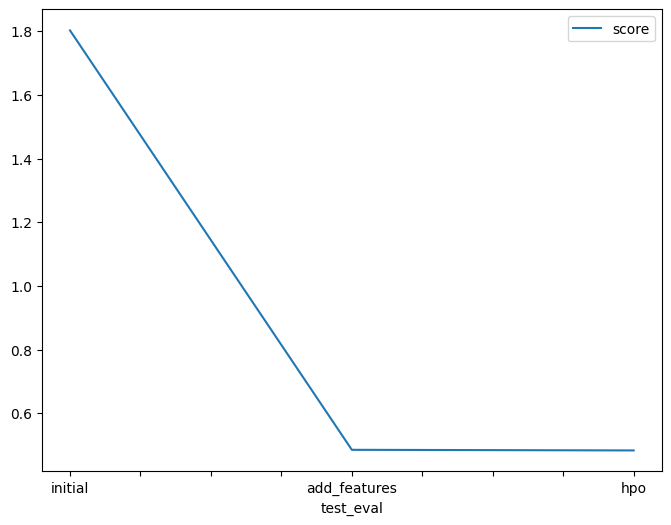

In [55]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80302, 0.48478 , 0.48281]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [56]:
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "timelimit": ["time_limit = 600", "time_limit=600", "time_limit=600"],
    "presets": ["presets='best_quality'", "presets='best_quality'", "presets='best_quality'"],
    "hp-method": ["none", "problem_type = 'regression'", "tabular autogluon"],
    "score": ["1.80302", "0.48478" , "0.48281"]
})

,model,timelimit,presets,hp-method,score
0,initial,time_limit = 600,presets='best_quality',none,1.80302
1,add_features,time_limit=600,presets='best_quality',problem_type = 'regression',0.48478
2,hpo,time_limit=600,presets='best_quality',tabular autogluon,0.48281
